In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
labels = os.listdir(r"/content/drive/MyDrive/train ")

In [16]:
labels

['yawn', 'no_yawn', 'Open', 'Closed']

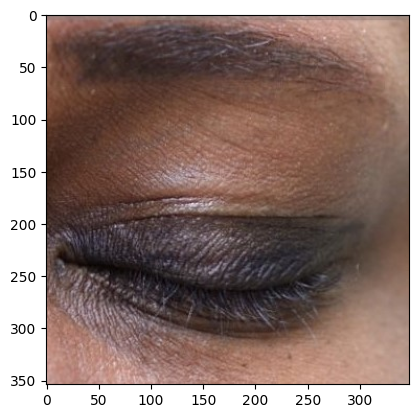

In [18]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"/content/drive/MyDrive/train /Closed/_113.jpg"))

In [19]:
a = plt.imread(r"/content/drive/MyDrive/train /yawn/158.jpg")

In [20]:
a.shape


(480, 640, 3)

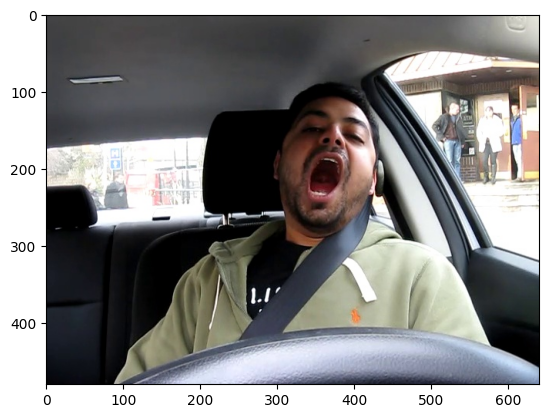

In [21]:
plt.imshow(plt.imread(r"/content/drive/MyDrive/train /yawn/158.jpg"))

In [22]:
def face_for_yawn(direc=r"/content/drive/MyDrive/train ", face_cas_path=r"/content/drive/MyDrive/data/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

yawn_no_yawn = face_for_yawn()

0
1


In [23]:
def get_data(dir_path=r"/content/drive/MyDrive/train ", face_cas=r"/content/drive/MyDrive/data/haarcascade_frontalface_default.xml", eye_cas=r"/content/drive/MyDrive/data/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data


In [24]:
data_train = get_data()


2
3


In [25]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [26]:
new_data = append_data()


0
1
2
3


<ipython-input-25-be15ac3ad549>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [27]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)


In [28]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [29]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [30]:
y = np.array(y)


In [31]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [32]:
len(X_test)


578

In [33]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)
train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [34]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [35]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))


Epoch 1/50
43/43 [==============================] - 26s 262ms/step - loss: 1.2149 - accuracy: 0.4974 - val_loss: 0.8102 - val_accuracy: 0.6678
Epoch 2/50
43/43 [==============================] - 8s 183ms/step - loss: 0.5612 - accuracy: 0.7706 - val_loss: 0.4222 - val_accuracy: 0.7976
Epoch 3/50
43/43 [==============================] - 11s 249ms/step - loss: 0.4053 - accuracy: 0.8337 - val_loss: 0.2632 - val_accuracy: 0.9048
Epoch 4/50
43/43 [==============================] - 9s 199ms/step - loss: 0.3357 - accuracy: 0.8612 - val_loss: 0.3162 - val_accuracy: 0.9118
Epoch 5/50
43/43 [==============================] - 10s 223ms/step - loss: 0.3089 - accuracy: 0.8805 - val_loss: 0.2139 - val_accuracy: 0.9083
Epoch 6/50
43/43 [==============================] - 10s 222ms/step - loss: 0.2710 - accuracy: 0.8790 - val_loss: 0.2168 - val_accuracy: 0.9152
Epoch 7/50
43/43 [==============================] - 9s 204ms/step - loss: 0.2821 - accuracy: 0.8894 - val_loss: 0.2041 - val_accuracy: 0.9187
Ep

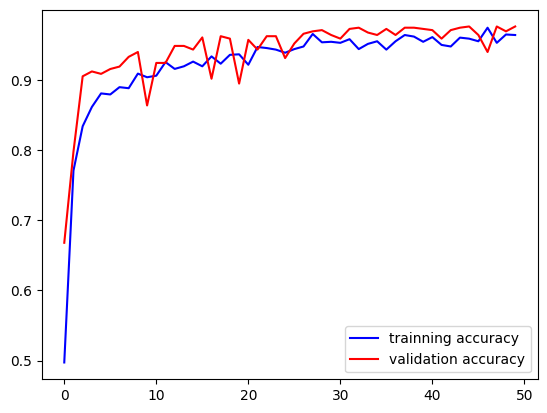

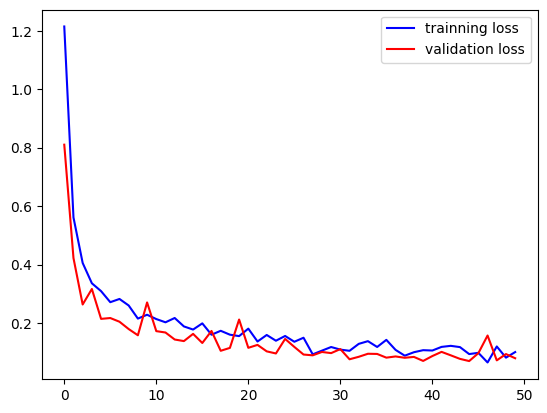

In [36]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()


In [37]:
model.save("/content/drive/MyDrive/drowiness_new7.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
model.save("/content/drive/MyDrive/drowiness_new7.model")

In [39]:
prediction = model.predict(X_test)
predicted_classes = np.argmax(prediction, axis=1)

19/19 [==============================] - 1s 24ms/step


In [40]:
prediction

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [41]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [42]:
from sklearn.metrics import classification_report
y_true = np.argmax(y_test, axis=1)
prediction = np.argmax(prediction, axis=1)
print(classification_report(y_true, prediction, target_names=labels_new))


              precision    recall  f1-score   support

        yawn       0.73      0.86      0.79        63
     no_yawn       0.88      0.70      0.78        74
      Closed       0.93      0.97      0.95       215
        Open       0.96      0.94      0.95       226

    accuracy                           0.91       578
   macro avg       0.88      0.87      0.87       578
weighted avg       0.91      0.91      0.91       578



In [43]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D

# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(145, 145, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)

# Add custom dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes, adjust as needed

# Compile the model
model.compile(loss='categorical_crossentropy        ', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 16813124 (64.14 MB)
Trainable params: 2098436 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [44]:
from keras.callbacks import ModelCheckpoint

# Number of classes
num_classes = 4

# Define the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Specify the number of epochs
epochs = 120  # Adjust as needed

# Set up model checkpoints to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


Epoch 1/120
43/43 [==============================] - 14s 245ms/step - loss: 0.4864 - accuracy: 0.8003 - val_loss: 0.1804 - val_accuracy: 0.9170


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/120
43/43 [==============================] - 11s 266ms/step - loss: 0.2533 - accuracy: 0.8953 - val_loss: 0.1557 - val_accuracy: 0.9481
Epoch 3/120
43/43 [==============================] - 11s 250ms/step - loss: 0.1885 - accuracy: 0.9169 - val_loss: 0.1243 - val_accuracy: 0.9533
Epoch 4/120
43/43 [==============================] - 11s 268ms/step - loss: 0.2038 - accuracy: 0.9235 - val_loss: 0.1146 - val_accuracy: 0.9464
Epoch 5/120
43/43 [==============================] - 11s 255ms/step - loss: 0.1313 - accuracy: 0.9458 - val_loss: 0.1088 - val_accuracy: 0.9567
Epoch 6/120
43/43 [==============================] - 10s 227ms/step - loss: 0.1206 - accuracy: 0.9547 - val_loss: 0.0983 - val_accuracy: 0.9654
Epoch 7/120
43/43 [==============================] - 9s 202ms/step - loss: 0.1325 - accuracy: 0.9465 - val_loss: 0.1005 - val_accuracy: 0.9654
Epoch 8/120
43/43 [==============================] - 11s 261ms/step - loss: 0.1164 - accuracy: 0.9532 - val_loss: 0.0902 - val_accuracy: 

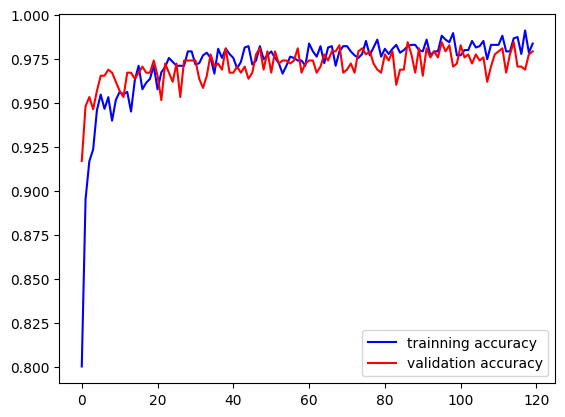

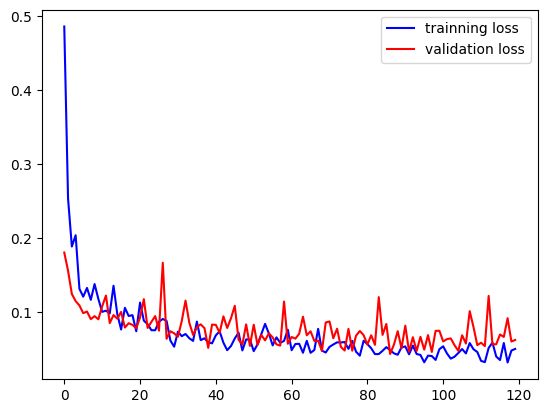

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()


In [46]:
prediction = model.predict(X_test)
predicted_classes = np.argmax(prediction, axis=1)


19/19 [==============================] - 1s 63ms/step


In [47]:
prediction

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 7.8538745e-33, 9.7938194e-34, 0.0000000e+00]],
      dtype=float32)

In [48]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]


In [49]:
from sklearn.metrics import classification_report
y_true = np.argmax(y_test, axis=1)
prediction = np.argmax(prediction, axis=1)
print(classification_report(y_true, prediction, target_names=labels_new))


              precision    recall  f1-score   support

        yawn       0.46      0.84      0.60        63
     no_yawn       0.65      0.81      0.72        74
      Closed       0.99      0.65      0.78       215
        Open       0.93      0.95      0.94       226

    accuracy                           0.81       578
   macro avg       0.76      0.81      0.76       578
weighted avg       0.87      0.81      0.81       578



In [50]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("/content/drive/MyDrive/drowiness_new7.h5")

In [52]:
import cv2

def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    try:
        img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)

        if img_array is None:
            raise FileNotFoundError(f"Unable to read the image at path: {filepath}")

        img_array = img_array / 255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    except Exception as e:
        print(f"Error in prepare function: {e}")
        return None


In [53]:
prediction = model.predict([prepare(r"/content/drive/MyDrive/train /Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 219ms/step


2

In [56]:
prediction = model.predict([prepare(r"/content/drive/MyDrive/train /Open/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 53ms/step


3

In [55]:
prediction = model.predict([prepare(r"/content/drive/MyDrive/train /yawn/12.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 23ms/step


3

In [58]:
prediction = model.predict([prepare(r"/content/drive/MyDrive/train /no_yawn/1008.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 64ms/step


3

1/1 [==============================] - 0s 28ms/step


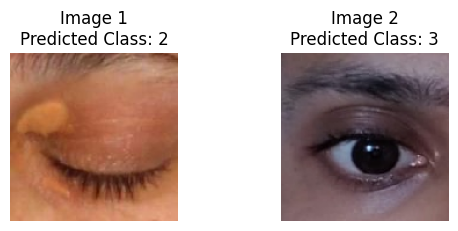

In [60]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
trained_model = load_model('best_model.h5')
new_image_paths = [
    '/content/drive/MyDrive/train /Closed/_1.jpg',
    '/content/drive/MyDrive/train /Open/_0.jpg'
]

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(145, 145))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img

for i, img_path in enumerate(new_image_paths):
    img_array, original_img = preprocess_image(img_path)
    predictions = trained_model.predict(img_array)
    predicted_class = np.argmax(predictions)
    plt.subplot(2, 2, i+1)
    plt.imshow(original_img)
    plt.title(f"Image {i+1}\nPredicted Class: {predicted_class}")
    plt.axis('off')
plt.show()
